# 1. Import Libraries

In [5]:
import warnings
warnings.filterwarnings('ignore')
from numba import jit, cuda 


from sklearn.utils import resample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from tqdm import tqdm_notebook as tqdm
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from langdetect import detect
import random
from random import shuffle
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import CSVLogger
from keras import backend as K
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dropout
from keras.layers import Flatten
from keras.models import load_model
from keras.models import model_from_json
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding


import json




Using TensorFlow backend.


In [1]:
def Plot_Metrics(history):
    history_dict = history.history
    history_dict = pd.DataFrame(history_dict)

    variables = history_dict.columns
    scores = pd.DataFrame(columns = ['scores'])

    x= []
    epochs = []
    
    for i in variables:
        x.append(list(history_dict[i]))
        epochs.append(list(range(1,len(history_dict)+1)))

    epochs = np.array(epochs).flatten()
    x = np.array(x).flatten()   
    
    y = [['loss']*int(len(x)/6), ['f1_m']*int(len(x)/6), ['acc']*int(len(x)/6)]*2
    y = [item for sublist in y for item in sublist]
 
    j = [['Train']*int(len(x)/2), ['val']*int(len(x)/2)]
    j = [item for sublist in j for item in sublist]
    
    df = pd.concat([pd.DataFrame(data=x, columns=['score']),
                pd.DataFrame(data=y,columns=['score_type']),
                pd.DataFrame(data=j,columns=['set_type']),
                pd.DataFrame(data=epochs,columns=['epochs'])],
                axis=1)
    
    f, axes = plt.subplots(3, figsize=(10, 8), sharex=True)
    
    sns.lineplot(x="epochs", y="score", hue="set_type", data=df[df['score_type']=='acc'],
                 ax=axes[0],style="set_type", markers=True).set(ylabel='acc')
    sns.lineplot(x="epochs", y="score", hue="set_type", data=df[df['score_type']=='f1_m'],
                 ax=axes[1],style="set_type", markers=True).set(ylabel='f1_m')
    sns.lineplot(x="epochs", y="score", hue="set_type", data=df[df['score_type']=='loss'],
                 ax=axes[2],style="set_type", markers=True).set(ylabel='loss')
    
    plt.tight_layout()

In [89]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                VAL                                                        ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                TEST                                                       ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

In [3]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [74]:
def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w",fontdict = {'size': 18})

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    fig.set_size_inches(9, 6)
    return plt.show()

# 2. Import Data, Overview

In [ ]:
data_reviews = pd.read_csv('steam_reviews.csv')

In [ ]:
data_reviews.head()

In [ ]:
data_reviews.describe()

#### Checking if there are rows with empty cells:

In [ ]:
data_reviews.isna().sum()

In [ ]:
data_reviews.dropna(inplace = True)
data_reviews.reset_index(drop = True, inplace = True)

In [ ]:
data_reviews.shape

# 3. Preprocessing

## The result of all the pre-processing is saved in the file "Data_Processed.csv" and loaded in chapter 4

- The fisrt step is clean the reviews of the dataset of words that are not important for the analysis, remove every numerical data and puctuation, transform all the text into lowercase...etc

In [ ]:
def clean(text_list, lemmatize, stemmer, stop_word):
    """
    Function that a receives a list of strings and preprocesses it.
    
    :param text_list: List of strings.
    :param lemmatize: Tag to apply lemmatization if True.
    :param stemmer: Tag to apply the stemmer if True.
    """
    updates = []
    
    for j in tqdm(range(len(text_list))):
        
        text = text_list[j]
        
        #LOWERCASE TEXT
        text = text.lower()
        
        #REMOVE NUMERICAL DATA AND PUNCTUATION
        text = re.sub("[^a-zA-Z-zÀ-ÿ]", ' ', text)
        
        #REMOVE TAGS
        text = BeautifulSoup(text).get_text()
        
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        if stemmer:
            text = " ".join(snowball_stemmer.stem(word) for word in text.split())
            
        if stop_word:
            text = [w for w in text.split() if not w in stop]
            text = " ".join(text)
        
        updates.append(text)
        
    return updates

def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"review": list_updated}))

- Here is a collection of English words that are considered as non important:

In [ ]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [ ]:
stop_words = {'a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any',
 'are', 'aren', 'as', 'at', 'be', 'because', 'been', 'before',
 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'd', 'did', 'didn', 'do', 'does', 'doing', 'don', 'down', 'during', 'each',
 'few', 'for', 'from', 'further', 'had', 'has', 'hasn', 'have', 'haven', 'having', 'he', 'her', 'here',
 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', "it's", 'its', 'itself',
 'just', 'll', 'm', 'ma', 'me', 'mightn', 'more',
 'most', 'mustn', 'my', 'myself', 'no', 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or',
 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're',
 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'so', 'some', 'such', 't', 'than',
 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through',
 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'we', 'were', 'weren', 'what', 'when', 'where', 'which', 'while', 'who', 'whom',
 'why', 'will', 'with', 'won', 'y', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves'}

In [ ]:
updates = clean(data_reviews['review'], lemmatize = True, stemmer = False, stop_word = True)

In [ ]:
update_df(data_reviews, updates)

- Next step is to calculate the number of words per review. With that values we are going to remove the reviews with just one word.
- The goal is to identify the reviews that are writed in English and simplify the data. It is neccesary more that one word in order to identify the language.

In [ ]:
length_review = []
for i in range(0, len(data_reviews)):
    length_review.append(len(data_reviews['review'][i].split(' ')))

In [ ]:
data_reviews['length_review'] = length_review

In [ ]:
data_reviews.groupby('length_review').head()

In [ ]:
data_reviews.groupby('length_review')['recommendation'].count().head(10)

In [ ]:
data_reviews = data_reviews[data_reviews['length_review'] > 1].reset_index(drop = True)

In [ ]:
data_reviews.head(10)

- Next step is to detect the reviews writed in English. This process is slow. It takes around an hour...

In [ ]:
language = []
for i in tqdm(range(0,len(data_reviews))):
    language.append(detect(data_reviews['review'][i]))

In [ ]:
data_reviews['language'] = language

In [ ]:
data_reviews.head(5)

- Transforming into a binary classification:

In [ ]:
data_reviews.loc[data_reviews['recommendation'] == 'Not Recommended', 'Label'] = 0
data_reviews.loc[data_reviews['recommendation'] == 'Recommended', 'Label'] = 1

- Saving the processed dataset into a .csv file:

In [ ]:
data_reviews.to_csv('Data_Processed.csv', index=False)

# 4) MODELS

### Every model created and trained during this notebook is saved in a .h5 file in order to be loaded when it is necessary with its history saved in a .csv file.

- Analyzing which is the most common language and keeping just the reviews writed in that language:

In [6]:
data_reviews = pd.read_csv('Data_Processed.csv')

In [7]:
data_reviews.groupby('language').count().sort_values(['recommendation'], ascending=False)['recommendation'].head(5)

language
en    297246
da     13821
so     11103
no      8531
af      7667
Name: recommendation, dtype: int64

In [8]:
data_reviewsEN = data_reviews[data_reviews['language'] == 'en']

In [9]:
data_reviewsEN.shape

(297246, 11)

In [10]:
data_reviewsEN.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,length_review,language,Label
1,2019-02-07,0,0,892,False,Recommended,good game although bit overpriced opinion pref...,Expansion - Hearts of Iron IV: Man the Guns,17,en,1.0
2,2018-06-14,126,1086,676,False,Recommended,review wrote one probably serious one wrote st...,Dead by Daylight,191,en,1.0
3,2017-06-20,85,2139,612,False,Recommended,disclaimer survivor main play game fun competi...,Dead by Daylight,132,en,1.0
5,2017-09-17,12,228,48,False,Recommended,review wrote one probably serious one wrote st...,Dead by Daylight,191,en,1.0
7,2018-09-21,2,54,400,False,Recommended,longtime dead daylight player know horror game...,Dead by Daylight,164,en,1.0


In [11]:
data_reviewsEN.groupby('recommendation').count()['Label']

recommendation
Not Recommended    101440
Recommended        195806
Name: Label, dtype: int64

## 4.1) Embeddings with ReSample

In [12]:
data_reviewsEN.length_review.quantile(q=0.99) 

244.0

In [13]:
data = list(data_reviewsEN['review'])
target = list(data_reviewsEN['Label'])

- The first parameter to the Embedding() layer is the vocabulary (number of unique words in the data):

In [14]:
all_words = []
for review in data:
    tokenize_word = word_tokenize(review)
    for word in tokenize_word:
        all_words.append(word)

In [15]:
unique_words = set(all_words)
vocabulary_length = len(unique_words)
print(vocabulary_length)

135979


- Using the "one_hot" function. The function takes sentence and the total length of the vocabulary and returns the sentence in numeric form.

In [16]:
embedded_reviews = [one_hot(review, vocabulary_length) for review in data]

In [17]:
print(embedded_reviews[12])
print(data[12])

[9881, 36128, 79901, 112772, 48640]
think pretty good job far


In [18]:
padded_reviews = pad_sequences(embedded_reviews, 250, padding='post')

In [19]:
print(padded_reviews[12])

[  9881  36128  79901 112772  48640      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      

- Splitting:

In [20]:
X_train, x_test, y_train, y_test = train_test_split(padded_reviews, target,
                                                    test_size = 0.15,
                                                    random_state = 500
                                                    ,stratify = target)

In [ ]:
#X_val, X_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
#                                                    test_size = 0.5,
#                                                    random_state = 200
#                                                    ,stratify = y_val_test)

#### Upsampling The Training Data

In [21]:
X = pd.concat([pd.DataFrame(data=X_train), pd.Series(y_train, name = 'Label')], axis=1)
not_recommended = X[X.Label==0]
recommended = X[X.Label==1]

In [22]:
# upsample minority
not_recommended_upsampled = resample(not_recommended,
                            replace=True, # sample with replacement
                            n_samples=len(recommended), # match number in majority class
                            random_state=27) # reproducible results

In [23]:
upsampled = pd.concat([recommended, not_recommended_upsampled])
upsampled.Label.value_counts()

0.0    166435
1.0    166435
Name: Label, dtype: int64

In [24]:
X_train_up = upsampled.drop(['Label'], axis=1)
y_train_up = upsampled['Label']

In [25]:
X_train_up = X_train_up.to_numpy()
y_train_up = list(y_train_up)

In [26]:
print(len(X_train_up))

332870


In [27]:
X_train_up, X_val, y_train_up, y_val = train_test_split(X_train_up, y_train_up,
                                                    test_size = 0.15,
                                                    random_state = 200
                                                    ,stratify = y_train_up)

#### model 01:

In [35]:
model = Sequential()
model.add(Embedding(input_dim = vocabulary_length, output_dim = 40, input_length=250))
model.add(Flatten())
model.add(Dense(5, kernel_regularizer=regularizers.l2(0.15), activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(1, activation='sigmoid'))

In [36]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[f1_m,'acc'])

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 40)           5439160   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 50005     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 5,489,171
Trainable params: 5,489,171
Non-trainable params: 0
_________________________________________________________________


In [38]:
import tensorflow as tf
from keras.callbacks import TensorBoard
import datetime
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [39]:
model.fit(X_train_up, 
          y_train_up, 
          epochs= 50, 
          verbose=1, 
          validation_data = (X_val, y_val), 
          callbacks=[tensorboard_callback], 
          batch_size = 500)

Train on 282939 samples, validate on 49931 samples
Epoch 1/50
282939/282939 [==============================] - 76s 269us/step - loss: 0.5883 - f1_m: 0.7680 - acc: 0.7440 - val_loss: 0.4609 - val_f1_m: 0.8251 - val_acc: 0.8306
Epoch 2/50
282939/282939 [==============================] - 55s 194us/step - loss: 0.4418 - f1_m: 0.8317 - acc: 0.8314 - val_loss: 0.4095 - val_f1_m: 0.8465 - val_acc: 0.8446
Epoch 3/50
282939/282939 [==============================] - 53s 189us/step - loss: 0.4099 - f1_m: 0.8447 - acc: 0.8453 - val_loss: 0.3964 - val_f1_m: 0.8484 - val_acc: 0.8485
Epoch 4/50
282939/282939 [==============================] - 56s 198us/step - loss: 0.3934 - f1_m: 0.8512 - acc: 0.8523 - val_loss: 0.3875 - val_f1_m: 0.8550 - val_acc: 0.8503
Epoch 5/50
282939/282939 [==============================] - 56s 199us/step - loss: 0.3821 - f1_m: 0.8561 - acc: 0.8573 - val_loss: 0.3769 - val_f1_m: 0.8562 - val_acc: 0.8567
Epoch 6/50
282939/282939 [==============================] - 56s 199us/step

282939/282939 [==============================] - 56s 198us/step - loss: 0.1781 - f1_m: 0.9646 - acc: 0.9650 - val_loss: 0.4213 - val_f1_m: 0.8906 - val_acc: 0.8944
Epoch 48/50
282939/282939 [==============================] - 55s 194us/step - loss: 0.1763 - f1_m: 0.9652 - acc: 0.9655 - val_loss: 0.3978 - val_f1_m: 0.8897 - val_acc: 0.8937
Epoch 49/50
282939/282939 [==============================] - 56s 198us/step - loss: 0.1778 - f1_m: 0.9650 - acc: 0.9653 - val_loss: 0.4332 - val_f1_m: 0.8868 - val_acc: 0.8913
Epoch 50/50
282939/282939 [==============================] - 56s 197us/step - loss: 0.1745 - f1_m: 0.9661 - acc: 0.9664 - val_loss: 0.4219 - val_f1_m: 0.8874 - val_acc: 0.8925


In [40]:
#Saving the model:
model.save('model_embeddings01.h5')

In [28]:
#from keras.models import load_model
#model = load_model('model_embeddings.h5')

#### TensorBoard

In [41]:
from keras.callbacks import TensorBoard

In [42]:
%load_ext tensorboard.notebook

In [44]:
%tensorboard --logdir logs #'!kill 12084'

Reusing TensorBoard on port 6006 (pid 12084), started 23:50:24 ago. (Use '!kill 12084' to kill it.)

- Plot of the three parameters evaluated in the model:

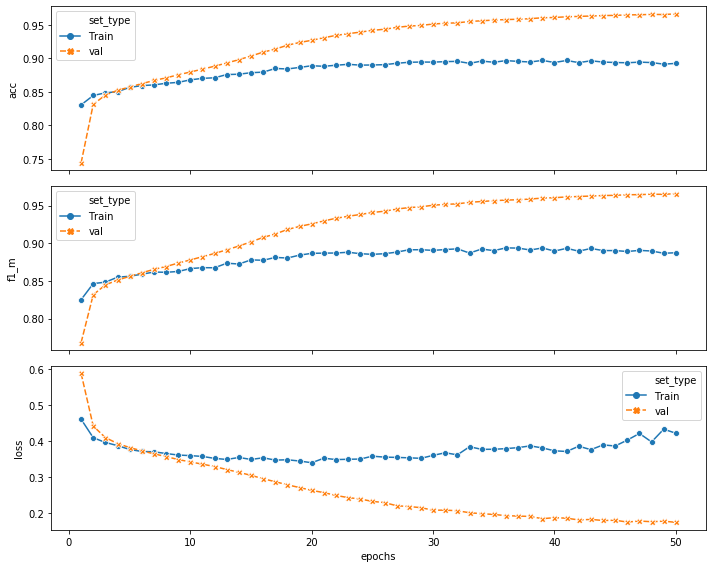

In [45]:
Plot_Metrics(model.history)

#### Model 02

In [46]:
model02 = Sequential()
model02.add(Embedding(input_dim = vocabulary_length, output_dim = 30, input_length=250))
model02.add(Flatten())
model02.add(Dense(5, kernel_regularizer=regularizers.l2(0.3), activation = 'relu'))
model02.add(Dropout(.3))
model02.add(Dense(1, activation='sigmoid'))

In [47]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model02.compile(optimizer=opt, loss='binary_crossentropy', metrics=[f1_m,'acc'])

In [50]:
model02.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 30)           4079370   
_________________________________________________________________
flatten_3 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 37505     
_________________________________________________________________
dropout_3 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6         
Total params: 4,116,881
Trainable params: 4,116,881
Non-trainable params: 0
_________________________________________________________________


In [48]:
model02.fit(X_train_up, 
          y_train_up, 
          epochs= 50, 
          verbose=1, 
          validation_data = (X_val, y_val), 
          callbacks=[tensorboard_callback], 
          batch_size = 1000)

Train on 282939 samples, validate on 49931 samples
Epoch 1/50
282939/282939 [==============================] - 32s 114us/step - loss: 0.7303 - f1_m: 0.6373 - acc: 0.6634 - val_loss: 0.5536 - val_f1_m: 0.8178 - val_acc: 0.8034
Epoch 2/50
282939/282939 [==============================] - 26s 93us/step - loss: 0.5208 - f1_m: 0.8028 - acc: 0.8036 - val_loss: 0.4673 - val_f1_m: 0.8358 - val_acc: 0.8364
Epoch 3/50
282939/282939 [==============================] - 27s 96us/step - loss: 0.4754 - f1_m: 0.8249 - acc: 0.8230 - val_loss: 0.4376 - val_f1_m: 0.8462 - val_acc: 0.8432
Epoch 4/50
282939/282939 [==============================] - 27s 96us/step - loss: 0.4524 - f1_m: 0.8341 - acc: 0.8314 - val_loss: 0.4214 - val_f1_m: 0.8473 - val_acc: 0.8449
Epoch 5/50
282939/282939 [==============================] - 26s 93us/step - loss: 0.4400 - f1_m: 0.8383 - acc: 0.8349 - val_loss: 0.4086 - val_f1_m: 0.8486 - val_acc: 0.8480
Epoch 6/50
282939/282939 [==============================] - 26s 94us/step - lo

282939/282939 [==============================] - 28s 98us/step - loss: 0.2594 - f1_m: 0.9334 - acc: 0.9323 - val_loss: 0.3832 - val_f1_m: 0.8848 - val_acc: 0.8883
Epoch 48/50
282939/282939 [==============================] - 27s 97us/step - loss: 0.2580 - f1_m: 0.9347 - acc: 0.9336 - val_loss: 0.3858 - val_f1_m: 0.8846 - val_acc: 0.8882
Epoch 49/50
282939/282939 [==============================] - 29s 102us/step - loss: 0.2561 - f1_m: 0.9354 - acc: 0.9343 - val_loss: 0.3874 - val_f1_m: 0.8827 - val_acc: 0.8866
Epoch 50/50
282939/282939 [==============================] - 28s 99us/step - loss: 0.2539 - f1_m: 0.9367 - acc: 0.9357 - val_loss: 0.3911 - val_f1_m: 0.8839 - val_acc: 0.8876


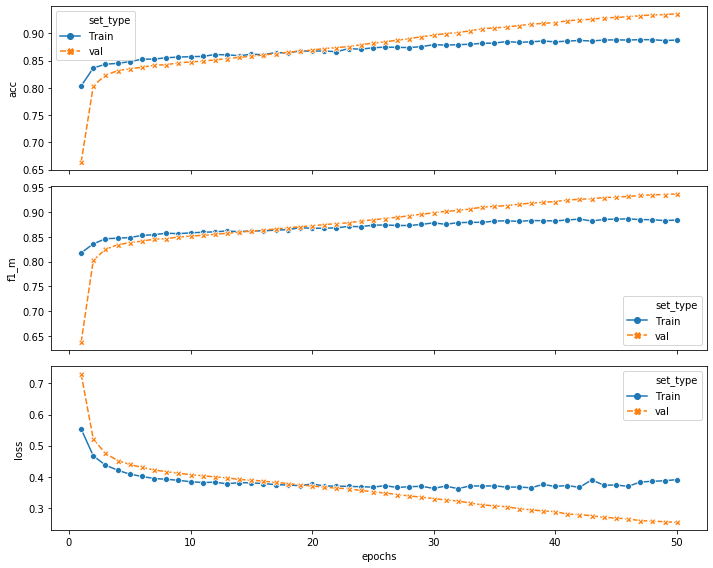

In [49]:
Plot_Metrics(model02.history)

#### Modelo03

In [59]:
model03 = Sequential()
model03.add(Embedding(input_dim = vocabulary_length, output_dim = 30, input_length=250))
model03.add(Flatten())
model03.add(Dense(5, kernel_regularizer=regularizers.l2(0.4), activation = 'relu'))
model03.add(Dropout(.3))
model03.add(Dense(1, activation='sigmoid'))

In [60]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model03.compile(optimizer=opt, loss='binary_crossentropy', metrics=[f1_m,'acc'])

In [61]:
model03.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 250, 30)           4079370   
_________________________________________________________________
flatten_5 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 37505     
_________________________________________________________________
dropout_5 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 6         
Total params: 4,116,881
Trainable params: 4,116,881
Non-trainable params: 0
_________________________________________________________________


In [62]:
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [63]:
model03.fit(X_train_up, 
          y_train_up, 
          epochs= 100, 
          verbose=1, 
          validation_data = (X_val, y_val), 
          callbacks=[tensorboard_callback], 
          batch_size = 1000)

Train on 282939 samples, validate on 49931 samples
Epoch 1/100
282939/282939 [==============================] - 31s 108us/step - loss: 0.7816 - f1_m: 0.5681 - acc: 0.6405 - val_loss: 0.5945 - val_f1_m: 0.7729 - val_acc: 0.7991
Epoch 2/100
282939/282939 [==============================] - 29s 104us/step - loss: 0.5643 - f1_m: 0.7955 - acc: 0.7982 - val_loss: 0.5134 - val_f1_m: 0.8330 - val_acc: 0.8372
Epoch 3/100
282939/282939 [==============================] - 30s 106us/step - loss: 0.5149 - f1_m: 0.8176 - acc: 0.8136 - val_loss: 0.4735 - val_f1_m: 0.8398 - val_acc: 0.8408
Epoch 4/100
282939/282939 [==============================] - 30s 106us/step - loss: 0.4877 - f1_m: 0.8256 - acc: 0.8191 - val_loss: 0.4504 - val_f1_m: 0.8465 - val_acc: 0.8446
Epoch 5/100
282939/282939 [==============================] - 30s 104us/step - loss: 0.4724 - f1_m: 0.8285 - acc: 0.8208 - val_loss: 0.4346 - val_f1_m: 0.8485 - val_acc: 0.8475
Epoch 6/100
282939/282939 [==============================] - 30s 104u

282939/282939 [==============================] - 31s 108us/step - loss: 0.3150 - f1_m: 0.9115 - acc: 0.9081 - val_loss: 0.3876 - val_f1_m: 0.8814 - val_acc: 0.8826
Epoch 48/100
282939/282939 [==============================] - 31s 108us/step - loss: 0.3124 - f1_m: 0.9122 - acc: 0.9089 - val_loss: 0.3929 - val_f1_m: 0.8793 - val_acc: 0.8818
Epoch 49/100
282939/282939 [==============================] - 31s 108us/step - loss: 0.3086 - f1_m: 0.9145 - acc: 0.9113 - val_loss: 0.3901 - val_f1_m: 0.8802 - val_acc: 0.8823
Epoch 50/100
282939/282939 [==============================] - 30s 107us/step - loss: 0.3068 - f1_m: 0.9150 - acc: 0.9118 - val_loss: 0.3924 - val_f1_m: 0.8788 - val_acc: 0.8809
Epoch 51/100
282939/282939 [==============================] - 31s 109us/step - loss: 0.3039 - f1_m: 0.9171 - acc: 0.9140 - val_loss: 0.3903 - val_f1_m: 0.8805 - val_acc: 0.8834
Epoch 52/100
282939/282939 [==============================] - 30s 107us/step - loss: 0.2993 - f1_m: 0.9183 - acc: 0.9154 - val_l

282939/282939 [==============================] - 51s 179us/step - loss: 0.2501 - f1_m: 0.9444 - acc: 0.9427 - val_loss: 0.4596 - val_f1_m: 0.8805 - val_acc: 0.8849
Epoch 94/100
282939/282939 [==============================] - 50s 178us/step - loss: 0.2399 - f1_m: 0.9441 - acc: 0.9423 - val_loss: 0.4678 - val_f1_m: 0.8837 - val_acc: 0.8864
Epoch 95/100
282939/282939 [==============================] - 51s 180us/step - loss: 0.2422 - f1_m: 0.9445 - acc: 0.9428 - val_loss: 0.5006 - val_f1_m: 0.8793 - val_acc: 0.8842
Epoch 96/100
282939/282939 [==============================] - 50s 178us/step - loss: 0.2426 - f1_m: 0.9442 - acc: 0.9424 - val_loss: 0.4840 - val_f1_m: 0.8821 - val_acc: 0.8855
Epoch 97/100
282939/282939 [==============================] - 40s 141us/step - loss: 0.2440 - f1_m: 0.9446 - acc: 0.9429 - val_loss: 0.4859 - val_f1_m: 0.8819 - val_acc: 0.8857
Epoch 98/100
282939/282939 [==============================] - 50s 177us/step - loss: 0.2451 - f1_m: 0.9443 - acc: 0.9426 - val_l

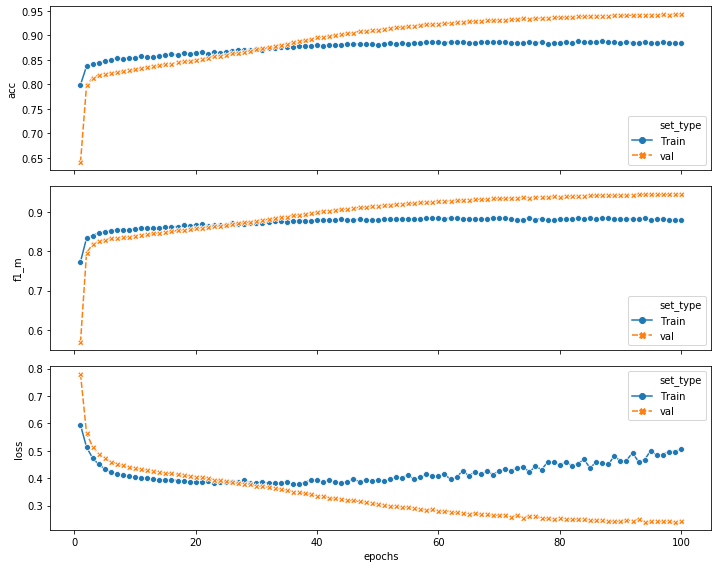

In [64]:
Plot_Metrics(model03.history)

#### Modelo 02 for 30 epochs

In [65]:
modelFinal = Sequential()
modelFinal.add(Embedding(input_dim = vocabulary_length, output_dim = 30, input_length=250))
modelFinal.add(Flatten())
modelFinal.add(Dense(5, kernel_regularizer=regularizers.l2(0.3), activation = 'relu'))
modelFinal.add(Dropout(.3))
modelFinal.add(Dense(1, activation='sigmoid'))

In [66]:
opt = keras.optimizers.Adam(learning_rate=0.001)
modelFinal.compile(optimizer=opt, loss='binary_crossentropy', metrics=[f1_m,'acc'])

In [67]:
modelFinal.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 250, 30)           4079370   
_________________________________________________________________
flatten_6 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 37505     
_________________________________________________________________
dropout_6 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 6         
Total params: 4,116,881
Trainable params: 4,116,881
Non-trainable params: 0
_________________________________________________________________


In [68]:
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [71]:
modelFinal.fit(X_train_up, 
          y_train_up, 
          epochs= 40, 
          verbose=1, 
          validation_data = (X_val, y_val), 
          callbacks=[tensorboard_callback], 
          batch_size = 1000)

Train on 282939 samples, validate on 49931 samples
Epoch 1/10
282939/282939 [==============================] - 31s 110us/step - loss: 0.3466 - f1_m: 0.8616 - acc: 0.8684 - val_loss: 0.3513 - val_f1_m: 0.8754 - val_acc: 0.8769
Epoch 2/10
282939/282939 [==============================] - 31s 109us/step - loss: 0.3433 - f1_m: 0.8646 - acc: 0.8713 - val_loss: 0.3460 - val_f1_m: 0.8767 - val_acc: 0.8795
Epoch 3/10
282939/282939 [==============================] - 30s 106us/step - loss: 0.3372 - f1_m: 0.8665 - acc: 0.8731 - val_loss: 0.3442 - val_f1_m: 0.8784 - val_acc: 0.8805
Epoch 4/10
282939/282939 [==============================] - 29s 104us/step - loss: 0.3352 - f1_m: 0.8676 - acc: 0.8743 - val_loss: 0.3473 - val_f1_m: 0.8776 - val_acc: 0.8812
Epoch 5/10
282939/282939 [==============================] - 31s 108us/step - loss: 0.3306 - f1_m: 0.8707 - acc: 0.8770 - val_loss: 0.3448 - val_f1_m: 0.8802 - val_acc: 0.8831
Epoch 6/10
282939/282939 [==============================] - 30s 106us/step

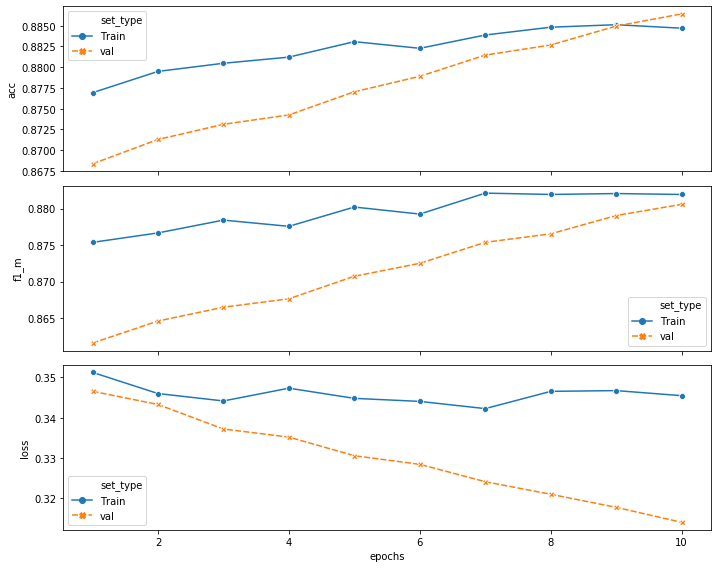

In [73]:
Plot_Metrics(modelFinal.history)

In [72]:
#Saving the model:
modelFinal.save('model_embeddingsFinal.h5')

In [ ]:
## Estimating

In [82]:
predictions = model.predict(x_test)
predictions = [round(x[0]) for x in predictions]
predictions[:5]

[1.0, 1.0, 1.0, 0.0, 1.0]

In [86]:
predictions_val = model.predict(X_val)
predictions_val = [round(x[0]) for x in predictions_val]
predictions_val[:5]

[1.0, 1.0, 0.0, 0.0, 1.0]

In [83]:
y_test[:5]

[0.0, 1.0, 1.0, 0.0, 1.0]

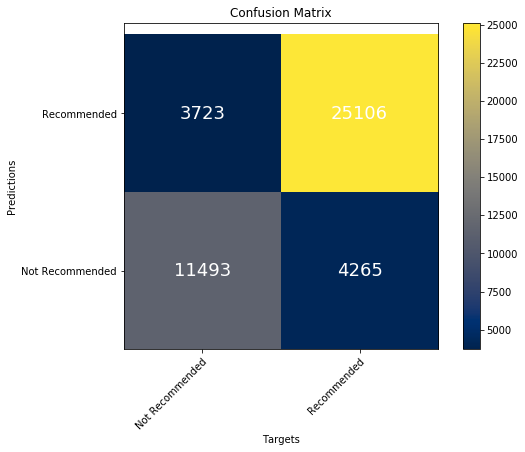

In [84]:
from sklearn.metrics import confusion_matrix

plot_cm(confusion_matrix(predictions, y_test), ['Not Recommended','Recommended'])

In [90]:
metrics(y_val, predictions_val , y_test, predictions) 

___________________________________________________________________________________________________________
                                                VAL                                                        
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.90     24966
         1.0       0.93      0.85      0.89     24965

    accuracy                           0.89     49931
   macro avg       0.90      0.89      0.89     49931
weighted avg       0.90      0.89      0.89     49931

[[23322  1644]
 [ 3725 21240]]
___________________________________________________________________________________________________________
                                                TEST                                                       
------------------------------------------------------------------------------------------------------